**NOTE:** I highly recommend using google colab to run this notebook, since I encountered too many problems running this notebook in vscode.

# 1. Preparation



1. Use pytorch v2.0.0 and torchvision v0.15.1


In [1]:
!pip install torch==2.0.0 torchvision==0.15.1

2. Install MMengine, MMCV, and MMDet

In [2]:
!pip install -U openmim
!mim install mmengine
!mim install 'mmcv>=2.0.0rc1'
!mim install 'mmdet>=3.0.0rc0'

Looking in links: https://download.openmmlab.com/mmcv/dist/cu117/torch2.0.0/index.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu117/torch2.0.0/index.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu117/torch2.0.0/index.html


3. Install MMOCR

In [3]:
!git clone https://github.com/open-mmlab/mmocr.git
%cd mmocr
!pip install -v -e .
# "-v" increases pip's verbosity.
# "-e" means installing the project in editable mode,
# That is, any local modifications on the code will take effect immediately.

fatal: destination path 'mmocr' already exists and is not an empty directory.
/content/mmocr
Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
Obtaining file:///content/mmocr
  Running command python setup.py egg_info
  running egg_info
  creating /tmp/pip-pip-egg-info-hasfn7dx/mmocr.egg-info
  writing manifest file '/tmp/pip-pip-egg-info-hasfn7dx/mmocr.egg-info/SOURCES.txt'
  writing manifest file '/tmp/pip-pip-egg-info-hasfn7dx/mmocr.egg-info/SOURCES.txt'
  Preparing metadata (setup.py) ... done
  Attempting uninstall: mmocr
    Found existing installation: mmocr 1.0.1
    Uninstalling mmocr-1.0.1:
      Removing file or directory /usr/local/lib/python3.10/dist-packages/mmocr.egg-link
      Removing pth entries from /usr/local/lib/python3.10/dist-packages/easy-install.pth:
      Removing entry: /content/mmocr
      Successfully uninstalled mmocr-1.0.1
  Running setup.py develop for mmocr
    Running command python setup.py develop
    running develop
   

In [4]:
%cd ../

/content


4. Prepare the necessary libraries

In [5]:
import cv2
import json
import numpy as np
import os
import shutil
from pathlib import Path
from typing import Dict, List, Tuple

# 2. Review pre-trained model

Perform end-to-end OCR with pretrained recognizer and detector:

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
from mmocr.apis import MMOCRInferencer
infer = MMOCRInferencer(det='dbnetpp', rec='svtr-small')
result = infer('/content/drive/MyDrive/dataset_miniProject/testing/05.jpg', return_vis=True)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textdet/dbnetpp/dbnetpp_resnet50-oclip_fpnc_1200e_icdar2015/dbnetpp_resnet50-oclip_fpnc_1200e_icdar2015_20221101_124139-4ecb39ac.pth


Downloading: "https://download.openmmlab.com/mmocr/textdet/dbnetpp/dbnetpp_resnet50-oclip_fpnc_1200e_icdar2015/dbnetpp_resnet50-oclip_fpnc_1200e_icdar2015_20221101_124139-4ecb39ac.pth" to /root/.cache/torch/hub/checkpoints/dbnetpp_resnet50-oclip_fpnc_1200e_icdar2015_20221101_124139-4ecb39ac.pth


07/23 03:15:43 - mmengine - WARNING - Failed to search registry with scope "mmocr" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmocr" is a correct scope, or whether the registry is initialized.
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/svtr/svtr-small_20e_st_mj/svtr-small_20e_st_mj-35d800d6.pth


/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '
Downloading: "https://download.openmmlab.com/mmocr/textrecog/svtr/svtr-small_20e_st_mj/svtr-small_20e_st_mj-35d800d6.pth" to /root/.cache/torch/hub/checkpoints/svtr-small_20e_st_mj-35d800d6.pth


Output()

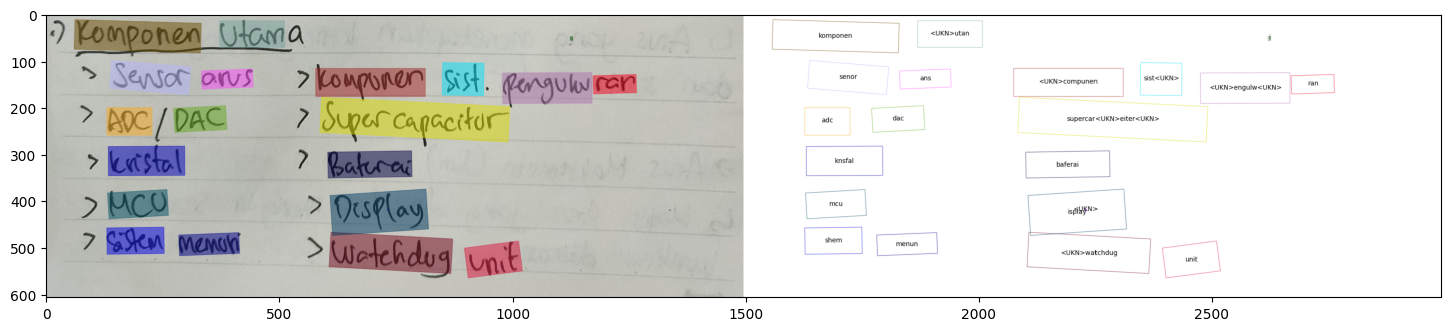

In [8]:
# Visualize the results
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 32))
plt.imshow(result['visualization'][0])
plt.show()

# 3. Prepare the functions

These functions are meant to convert label-studio format labels to mmocr format.

In [9]:
def xywh2xyxy(xywh: List[float], img_width: int, img_height: int) -> List[int]:
    """
    Change bounding box format xywh normalized to xyxy
    """
    x, y, w, h = xywh
    x = x * img_width / 100
    y = y * img_height / 100
    w = w * img_width / 100
    h = h * img_height / 100
    return [
        int(x),
        int(y),
        int(x + w),
        int(y + h),
    ]

def xyxy2poly(xyxy: List[int]) -> List[int]:
    """
    Change bounding box format from xyxy to polygon
    format xyxyxy...
    """
    x1, y1, x2, y2 = xyxy
    return [
        x1, y1, x1, y2, x2, y2, x2, y1
    ]


def create_instance_mmocr_anno(
    label_ls: Dict,
    text: str,
    img_width: int,
    img_height: int,
) -> Dict:
    """
    Conver annotation of a text instance from label studio format
    to MMOCR format
    """
    bbox = xywh2xyxy(
        [
            label_ls["x"],
            label_ls["y"],
            label_ls["width"],
            label_ls["height"],
        ],
        img_width,
        img_height,
    )
    instance_anno = {}
    instance_anno["bbox"] = bbox
    instance_anno["bbox_label"] = 0
    instance_anno["polygon"] = xyxy2poly(bbox)
    instance_anno["text"] = text
    instance_anno["ignore"] = False
    return instance_anno

def create_image_mmocr_anno(image_name: str, image_ls: Dict) -> Dict:
    """
    Conver annotation of an image from label studio format
    to MMOCR format
    """
    img_width = image_ls["label"][0]["original_width"]
    img_height = image_ls["label"][0]["original_height"]
    image_anno = {}
    image_anno["img_path"] = image_name
    image_anno["height"] = img_height
    image_anno["width"] = img_width
    image_anno["instances"] = [
        create_instance_mmocr_anno(lbl, txt, img_width, img_height)
        for lbl, txt in zip(image_ls["label"], image_ls["transcription"])
    ]
    return image_anno

def create_metainfo_det() -> Dict:
    """
    Metainfo for MMOCR text detection dataset
    """
    return {
        "dataset_type": "TextDetDataset",
        "task_name": "textdet",
        "category": [{"id": 0, "name": "text"}],
    }

def create_output_json(
    annotations: List[Dict],
    metainfo: Dict,
    output_path: Path
) -> None:
    """
    Dump MMOCR annotation JSON
    """
    output = {
        "metainfo": metainfo,
        "data_list": annotations
    }
    with open(output_path, "w") as f:
        json.dump(output, f)

def get_image_name(ls_image_path: str) -> str:
    """
    Label studio will write the image file name in format of
    '{random_id}-{original_image_name}'. So we only want to
    get the original image name, since that is the name that
    we have.
    """
    name = os.path.basename(ls_image_path)
    name = name[(name.find("-") + 1):]
    return name

def create_mmocr_det_anno(
    ls_anno_path: Path,
    train_images_dir: Path,
    test_images_dir: Path,
    output_dir: Path,
):
    """
    Create text detection dataset in MMOCR format
    """
    train_images = [p for p in train_images_dir.glob("*")]
    test_images = [p for p in test_images_dir.glob("*")]
    with open(ls_anno_path, "r") as f:
        ls_anno = json.load(f)
    image_annos = {}
    for ann in ls_anno:
        img_name = get_image_name(ann["ocr"])
        image_annos[img_name] = create_image_mmocr_anno(img_name, ann)

    output_dir.mkdir(parents=True, exist_ok=True)
    for p in [*train_images, *test_images]:
      shutil.copy(p, output_dir / p.name)
    create_output_json(
        annotations=[image_annos[p.name] for p in train_images],
        metainfo=create_metainfo_det(),
        output_path=output_dir / "textdet_train.json"
    )
    create_output_json(
        annotations=[image_annos[p.name] for p in test_images],
        metainfo=create_metainfo_det(),
        output_path=output_dir / "textdet_test.json"
    )

In [10]:
def create_metainfo_rec() -> Dict:
    """
    Metainfo for MMOCR text recognition dataset
    """
    return {
        "dataset_type": "TextRecogDataset",
        "task_name": "textrecog",
    }

def crop_images(
    src_annos: Dict,
    image_src_dir: Path,
    image_dst_dir: Path,
) -> List[Dict]:
    """
    Crop text images and extract the text annotations
    """
    image_path = image_src_dir / src_annos["img_path"]
    image = cv2.imread(str(image_path))
    image_name = image_path.stem

    anns = []
    for i, src_txt_anno in enumerate(src_annos["instances"]):
        dst_image_file = f"{image_name}_{i:05}.jpg"
        x1, y1, x2, y2 = src_txt_anno["bbox"]
        crop = image[y1:y2, x1:x2]
        cv2.imwrite(str(image_dst_dir / dst_image_file), crop)

        instance = [{"text": src_txt_anno["text"]}]
        crop_ann = {
            "img_path": dst_image_file,
            "height": crop.shape[0],
            "width": crop.shape[1],
            "instances": instance
        }
        anns.append(crop_ann)
    return anns


def create_split_anno(
    det_anno_path: Path,
    det_images_dir: Path,
    output_dir: Path,
    json_name: str,
):
    """
    Create formatted text recognition dataset for
    a dataset split.
    """
    with open(det_anno_path, "r") as f:
        det_anno = json.load(f)
    new_data_list = []
    for src_anno in det_anno["data_list"]:
        new_data_list += crop_images(
            src_anno,
            det_images_dir,
            output_dir,
        )
    new_anno = {
        "metainfo": create_metainfo_rec(),
        "data_list": new_data_list,
    }
    with open(output_dir / json_name, "w") as f:
      json.dump(new_anno, f)

def create_mmocr_rec_anno(
    det_root_dir: Path,
    output_dir: Path,
):
    """
    Create text recognition dataset in MMOCR format
    """
    output_dir.mkdir(parents=True, exist_ok=True)
    create_split_anno(
        det_root_dir / "textdet_train.json",
        det_root_dir,
        output_dir,
        "textrecog_train.json"
    )
    create_split_anno(
        det_root_dir / "textdet_test.json",
        det_root_dir,
        output_dir,
        "textrecog_test.json"
    )

# 4. Prepare the datasets

In [11]:
# change to path to your label-studio annotation JSON
LABEL_STUDIO_ANN = Path("/content/drive/MyDrive/dataset_miniProject/handwriting_dataset.json")
# change to path to your training images folder
TRAIN_IMGS = Path("/content/drive/MyDrive/dataset_miniProject/training")
# change to path to your test images folder
TEST_IMGS = Path("/content/drive/MyDrive/dataset_miniProject/testing")
# formatted dataset for text detection will be saved in the directory below
OUTPUT_DET_DIR = Path("/content/dataset-det")
# formatted dataset for text recognition will be saved in the directory below
OUTPUT_REC_DIR = Path("/content/dataset-rec")

create_mmocr_det_anno(
    LABEL_STUDIO_ANN,
    TRAIN_IMGS,
    TEST_IMGS,
    OUTPUT_DET_DIR,
)
create_mmocr_rec_anno(
    OUTPUT_DET_DIR,
    OUTPUT_REC_DIR,
)

# 5. Edit the configs for text detection

1. Change the root data in /content/mmocr/configs/textdet/_base_/datasets/icdar2015.py to /content/dataset-det
2. Change the train_cfg line in /content/mmocr/configs/textdet/_base_/schedules/schedule_sgd_1200e.py to `train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=50, val_interval=10)`
3. Change checkpoint in /content/mmocr/configs/textdet/_base_/default_runtime.py to     `checkpoint=dict(type='CheckpointHook', interval=10, max_keep_ckpts=1),`



Now, run the visualizations

In [ ]:
!python /content/mmocr/tools/visualizations/browse_dataset.py \
  "/content/mmocr/configs/textdet/dbnet/dbnet_resnet50-dcnv2_fpnc_1200e_icdar2015.py" \
  -o "/content/vis/det" \
  -m original

/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '
[                                                  ] 0/4, elapsed: 0s, ETA:/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:831: UserWarning: Warning: The polygon is out of bounds, the drawn polygon may not be in the image
  warnings.warn(
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 0.9 task/s, elapsed: 5s, ETA:     0s

# 6. Run the training for text detection

Check the visualizations, if it's correct then run the training

In [ ]:
!python "/content/mmocr/tools/train.py" \
  "/content/mmocr/configs/textdet/dbnet/dbnet_resnet50-dcnv2_fpnc_1200e_icdar2015.py" \
  --work-dir "/content/work_dir/det"

07/22 15:52:25 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0]
    CUDA available: False
    MUSA available: False
    numpy_random_seed: 2030302135
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.0+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=11.7, CUDNN_VERSION=8.5.0, CXX_COMPILER=/opt/rh/devtoolset-9/root/usr/bin/c++, CXX_FLAGS= -D_GLIBCXX_USE_CXX11_ABI=0 -fabi-

Save the result in google drive

In [ ]:
!cp -r "/content/work_dir" "/content/drive/MyDrive/mini-project-dibimbing/train-det"

# 7. Edit the configs for text recognition

1. Change the root-data from /content/mmocr/configs/textrecog/_base_/datasets/icdar2015.py to `dataset-rec`

2. Change the checkpoint from /content/mmocr/configs/textrecog/_base_/default_runtime.py to     `checkpoint=dict(type='CheckpointHook', interval=1, max_keep_ckpts=1),`

3. In the same file as the above change the val_evaluator to

```
val_evaluator = dict(
    _delete_=True,
    type='Evaluator',
    metrics=[
        dict(
            type='WordMetric',
            mode=['exact', 'ignore_case', 'ignore_case_symbol']),
        dict(type='CharMetric')
    ])
test_evaluator = val_evaluator
```

4. Change the train/test list in /content/mmocr/configs/textrecog/svtr/svtr-tiny_20e_st_mj.py to

```
train_list = [_base_.icdar2015_textrecog_train]
test_list = [_base_.icdar2015_textrecog_test]
```

5. In /content/mmocr/configs/textrecog/svtr/svtr-base_20e_st_mj.py change the batch_size to 128, and add

```
load_from = "https://download.openmmlab.com/mmocr/textrecog/svtr/svtr-base_20e_st_mj/svtr-base_20e_st_mj-ea500101.pth"
```







Now, run the following cell, then check for the vis

In [12]:
!python /content/mmocr/tools/visualizations/browse_dataset.py \
  "/content/mmocr/configs/textrecog/svtr/svtr-base_20e_st_mj.py" \
  -o "/content/vis/rec" \
  -m original

/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 167/167, 6.8 task/s, elapsed: 24s, ETA:     0s

In [14]:
!python "/content/mmocr/tools/train.py" \
  "/content/mmocr/configs/textrecog/svtr/svtr-base_20e_st_mj.py" \
  --work-dir "/content/work_dir/rec"

07/23 03:24:08 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 553431613
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.2, V12.2.140
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.0+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_

Save the result of the training in google drive

In [16]:
!cp -r "/content/work_dir" "/content/drive/MyDrive/train-rec"